<h1>SANS_spheres2 data reduction and simulations</h1>

By Wesley Stevense as part of the programme Applied Physics at TU Delft under the supervision of S.R. Parnell

In [1]:
import os
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from numba import njit
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from celluloid import Camera
from datetime import timedelta
from mcstasscript.interface import instr, plotter, functions, reader
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning


my_configurator = functions.Configurator()
my_configurator.set_mcrun_path('C:\\mcstas-2.7\\bin\\')
my_configurator.set_mcstas_path('C:\\mcstas-2.7\\lib\\')
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
%matplotlib inline

<h2>Theory</h2>

In [2]:
def sphere(Q,r,scale, delta_rho, background):
    """Theoretical sphere model"""
    V = (4/3)*np.pi*r**3
    return ((scale / V) * \
            (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\
            + background)

spheres=np.vectorize(sphere)

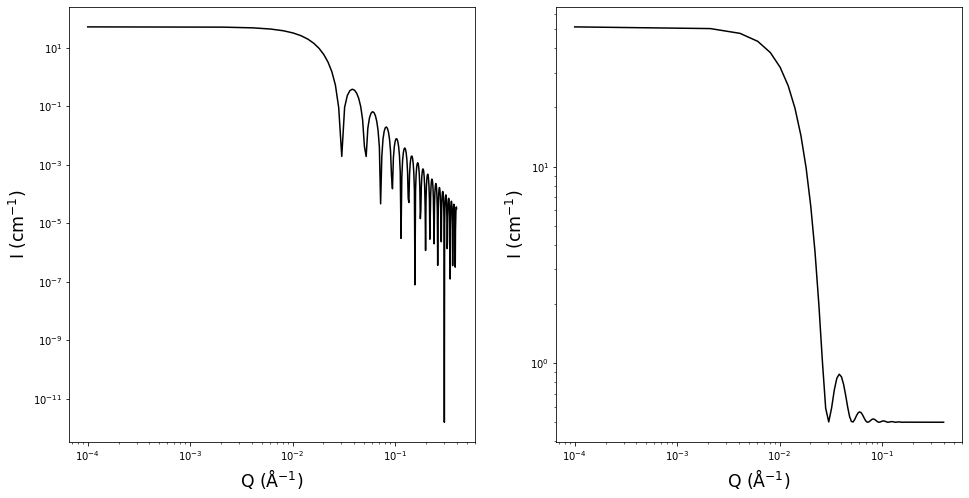

In [3]:
r = 150e-8 #cm
phi = 1e-3
drho = 6e10 #cm^{-2}

fig, ax = plt.subplots(1,2, figsize = (16,8))

Q = np.linspace(0.0001, 0.4, 200)
I = spheres(Q*1e8, r, phi, drho, 0)

ax[0].loglog(Q, I, color = (0,0,0))
ax[0].set_ylabel('I (cm$^{-1}$)', size = 'xx-large')
ax[0].set_xlabel('Q (Å$^{-1}$)', size = 'xx-large')

bg = 0.5 #cm^{-1}

I = spheres(Q*1e8, r, phi, drho, bg)

ax[1].loglog(Q, I, color = (0,0,0))
ax[1].set_ylabel('I (cm$^{-1}$)', size = 'xx-large')
ax[1].set_xlabel('Q (Å$^{-1}$)', size = 'xx-large')
plt.show()

<h2>Monochromatic SANS</h2>

In [4]:
#function to get the intensity for each q (radial collapse)
@njit
def get_q_profile(q_index, q_counts, I, I_err):
    """Function to do the radial collapse using unique q values. The input required for this function is:\
    q_output, q_index, q_counts = np.unique(q, return_index = True, return_counts = True) \
    and the sorted I values and their errors. here q is the sorted list of all q's, \
    and q_output will be the q values corresponding to the output of this function."""
    current_index = 0
    sum_q = 0
    sum_q_err = 0
    I_q = []
    I_q_err = []
    for num_counts in q_counts:
        for _ in range(num_counts): 
            sum_q += I[current_index]
            sum_q_err += I_err[current_index]**2
            current_index += 1
        I_q.append(sum_q / num_counts)
        I_q_err.append(np.sqrt(sum_q_err) / num_counts)
        sum_q = 0
        sum_q_err = 0
    return I_q, I_q_err

   
#function for data binning    
@njit
def binning(q_sorted, I_sorted, I_err_sorted, N_bins, binning_type = 'linear'):
    """Function that outputs the binned data (q value, intensity and error), meaning the average\
    intensity within N_bins bins of q_sorted"""
    q_min = np.nanmin(q_sorted)
    q_max = np.nanmax(q_sorted)
    #first_diff is used to calculate the first bin edge
    first_diff = np.diff(q_sorted)[np.nonzero(np.diff(q_sorted))][1]
    if len(q_sorted) != len(I_sorted): 
        raise ValueError('Please enter two arrays of the same size')
    #possibilty to implement a logarithmic binning
    if binning_type == 'linear':
        bin_edges = np.linspace(q_min - first_diff, q_max, N_bins+1)
    else: 
        raise TypeError('Please specify a valid binning type')
    I_sum_bin = np.zeros(N_bins)
    I_err_sum_bin = np.zeros(N_bins)
    q_sum_bin = np.zeros(N_bins)
    num_in_bin = np.zeros(N_bins)
    bin_index = 0
    for ind, q in enumerate(q_sorted):
        if q_sorted[ind] > bin_edges[bin_index + 1]:
            bin_index += 1
        I_sum_bin[bin_index] += I_sorted[ind]
        I_err_sum_bin[bin_index] += I_err_sorted[ind]**2
        q_sum_bin[bin_index] += q
        num_in_bin[bin_index] += 1
    I_bin = np.divide(I_sum_bin, num_in_bin)
    I_err_bin = np.divide(np.sqrt(I_err_sum_bin), num_in_bin)
    q_bin = np.divide(q_sum_bin, num_in_bin)
    return q_bin, I_bin, I_err_bin 

tu_delft_cyan = (0,166/255, 214/255) #rgb of TU Delft cyan color

In [5]:
def monochromatic_model(qmin= 0.0001, qmax=2.2, sc_aim=0.96, sans_aim = 0.95, sample_type = 'SANS_spheres2', beamstop = True, \
                        lambda0 = 5, pos_sample=6.2, L=6.3, pos_slit1 = 0.1, radius = 150, d = 0.001, \
                        incoherent_bg = 0, beamsize = 0.005, foldername = 'data', pixels = 129, ncounts = 1e8, \
                       detector_size = 2, focus_size = 0.01, print_components = False):
    
    pos_slit2 = pos_sample - 0.002
    pos_monitor1 = pos_sample - 0.001
    pos_monitor2 = pos_sample + 0.001
    pos_PSD = pos_sample + L
    pos_beamstop = pos_PSD - 0.001
    
    Instrument = instr.McStas_instr('Monochromatic')
    
    #adding the source
    Source = Instrument.add_component('Source', 'Source_simple') 
    Source.xwidth = 0.06 #m
    Source.yheight = 0.06 #m
    Source.focus_xw = focus_size #m
    Source.focus_yh = focus_size #m
    Source.lambda0 = lambda0
    Source.flux = 1e8
    Source.dist = pos_sample

    #adding the 
    Slit1 = Instrument.add_component('Slit1', 'Slit', AT = [0,0,pos_slit1], RELATIVE = 'Source')
    Slit1.radius = beamsize

    Slit2 = Instrument.add_component('Slit2', 'Slit', AT = [0,0,pos_slit2], RELATIVE = 'Source')
    Slit2.radius = beamsize 

    Monitor1 = Instrument.add_component('Monitor1', 'Monitor', AT = [0,0,pos_monitor1],\
                                        RELATIVE = 'Source')
    Monitor1.xwidth = 2 #m
    Monitor1.yheight = 2 #m
    Monitor1.restore_neutron = 1

    #add sample
    if sample_type == 'SANS_spheres2':
        Sample = Instrument.add_component('Sample', 'SANS_spheres2', AT = [0,0,pos_sample],\
                                          RELATIVE='Source')
        Sample.xwidth = 0.01 #m
        Sample.yheight = 0.01 #m
        Sample.zthick = d #m
        Sample.R = radius #AA 
        Sample.phi = 1e-3
        Sample.dsdw_inc = incoherent_bg #cm^-1
        Sample.Qmind = qmin
        Sample.Qmaxd = qmax
        Sample.sc_aim = sc_aim
        Sample.sans_aim = sans_aim
    elif sample_type == 'SANS_spheres':
        Sample = Instrument.add_component('Sample', 'Sans_spheres', AT = [0,0,pos_sample],\
                                      RELATIVE='Source')
        Sample.xwidth = 0.01 #m
        Sample.yheight = 0.01 #m
        Sample.zdepth = d #m
        Sample.R = radius #AA 
        Sample.Phi = 1e-3
        Sample.focus_xw = 2 #m
        Sample.focus_yh = 2 #m
        Sample.target_z = L
    elif sample_type == 'None':
        pass
    else: 
        raise TypeError('Please enter a valid sample type')
    

    #adding monitor
    Monitor2 = Instrument.add_component('Monitor2', 'Monitor', AT = [0,0,pos_monitor2],\
                                        RELATIVE = 'Source')
    Monitor2.xwidth = 2 #m
    Monitor2.yheight = 2 #m
    Monitor2.restore_neutron = 1
    
    #adding beamstop
    if beamstop: 
        Beamstop = Instrument.add_component('Beamstop', 'Beamstop', AT = [0,0,pos_beamstop],\
                                            RELATIVE = 'Source')
        Beamstop.radius = beamsize #m

    #adding detector
    PSD = Instrument.add_component('PSD', 'PSD_monitor', AT=[0,0,pos_PSD],\
                                   RELATIVE='Source')
    PSD.xwidth = detector_size #m
    PSD.yheight = detector_size #m 
    PSD.nx = pixels
    PSD.ny = pixels
    PSD.restore_neutron = 0
    PSD.filename = "\"PSD\""
    
    if print_components:
        Instrument.print_components()
    data = Instrument.run_full_instrument(foldername = foldername, nmpi=6,\
                                          ncount=ncounts, increment_folder_name = True)
    return data

In [6]:
class monochromatic(object): 
    def __init__(self, qmin = 0.000001, qmax=3, sc_aim=0.8, sans_aim = 0.95, sample_type = 'SANS_spheres2', beamstop = True, lambda0 = 5,\
                 pos_sample=6.2, L=6.3, pos_slit1 = 3, radius = 150, d = 0.001,\
                 incoherent_bg = 0, beamsize = 0.005, foldername = 'monochromatic_sans\\data', pixels = 249,\
                 ncounts = 1e8, detector_size = 2, focus_size = 0.01, print_components = False): 
        #load in data and create new data name if it already exists
        count = 0
        while os.path.exists(foldername):
            if count != 0:
                digits = len(str(count - 1))
                foldername = foldername[:-1*digits] + f'{count}'
            else: 
                foldername = foldername + f'{count}'
            count += 1
        data = monochromatic_model(qmin, qmax, sc_aim, sans_aim, sample_type, beamstop, lambda0, \
                                   pos_sample, L, pos_slit1, radius, d, incoherent_bg, beamsize, \
                                   foldername, pixels, ncounts, detector_size, focus_size, print_components)
        #save parameters in object
        self.sample_type = sample_type
        self.pixels = pixels
        self.L = L
        self.pos_sample = pos_sample
        self.radius = radius
        self.wavelength = lambda0
        self.beamsize = beamsize
        self.bg = incoherent_bg
        self.detector_size = detector_size
        self.d = d
        #load in data for PSD
        data = np.loadtxt(foldername + '/PSD.dat', skiprows=31)
        self.I_data = data[:self.pixels,:]
        self.I_err = data[self.pixels-2:2*self.pixels-2,:]
        self.monitor1 = np.loadtxt(foldername + '/Monitor1.dat', skiprows=21)[0]
        self.monitor2 = np.loadtxt(foldername + '/Monitor2.dat', skiprows=21)[0]
        self.monitor1_err = np.loadtxt(foldername + '/Monitor1.dat', skiprows=21)[1]
        self.monitor2_err = np.loadtxt(foldername + '/Monitor2.dat', skiprows=21)[1]
        #create a grid with all distances to center of PSD
        y, x = np.ogrid[0:self.pixels, 0:self.pixels]
        p_x = detector_size/self.pixels #m
        self.dist = p_x * np.sqrt((y-int(self.pixels/2))**2 + (x-int(self.pixels/2))**2) #(note: this requires the pixels to be square)
        #the angle for each point of PSD
        self.two_theta = np.arctan(self.dist/self.L)
        self.qmin = qmin
        self.qmax = qmax
        self.beamstop = beamstop
        self.T = np.loadtxt(foldername + '/Monitor2.dat', skiprows=21)[0] / np.loadtxt(foldername + '/Monitor1.dat', skiprows=21)[0]
        
    def scatterplot(self, title = False):
        """Generate scatterplot of PSD"""
        p_x = self.detector_size/self.pixels
        x=np.arange(-(self.pixels*p_x)/2, (self.pixels*p_x)/2, p_x)
        y=x
        plt.figure(figsize = (10,8))
        plt.pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')
        if title:
            plt.title("PSD measurement", size = 'large')
        plt.colorbar().set_label(label='$ln(I_s(x,y))$', size='xx-large')
        plt.xlabel('x (m)', size = 'large')
        plt.ylabel('y (m)', size = 'large')
        plt.show()
        
    def absolute_calibration(self, return_error = True):
        """Do the absolute calibration of the data"""
        p_x = self.detector_size/self.pixels
        domega = (p_x**2/self.L**2)*np.cos(self.two_theta)**3
        T = self.monitor2 / self.monitor1
        d = self.d * 100 #m
        if return_error: 
            T_err = np.sqrt((self.monitor2_err/self.monitor1)**2\
                           + ((self.monitor2*self.monitor1_err)/self.monitor1**2)**2)
            part_1 = (self.I_err/(self.monitor1*T*d*domega))**2
            part_2 = (self.I_data*self.monitor1_err/(self.monitor1**2*T*d*domega))**2
            part_3 = (self.I_data*T_err/(self.monitor1*T**2*d*domega))**2
            err = np.sqrt(part_1 + part_2 + part_3)
            return self.I_data / (self.monitor1*T*0.1*domega), err
        return self.I_data / (self.monitor1*T*d*domega)
        
        
    
    def intensity_plot(self, scale = 1, throw_away = 0, plot = False, do_bin = True,\
                       N_bins = 200, title = False, savefile = None):
        """Do the radial collaps and plot the absolutely calibrated data"""
        #get wavelength corresponding to each PSD "snapshot"
        q = 4*np.pi*np.sin(self.two_theta/2)/self.wavelength
        #get intensity and q sorted by q value
        q_sorted_indices = np.argsort(q.flat)
        I_q, I_q_err = self.absolute_calibration()
        I_q, I_q_err = I_q.flat[q_sorted_indices], I_q_err.flat[q_sorted_indices]
        q_sorted = q.flat[q_sorted_indices]
        q_sorted_unique, q_index, q_counts = np.unique(q_sorted, \
                                                       return_index = True, \
                                                       return_counts = True)
        I_q_avg, I_q_avg_err = get_q_profile(q_index, q_counts, I_q, I_q_err)
        if do_bin:
            q_binned, I_binned, I_binned_err = binning(q_sorted_unique, I_q_avg, I_q_avg_err, N_bins)
        else: 
            q_binned, I_binned ,I_binned_err = q_sorted_unique, I_q_avg, I_q_avg_err
        I_calculated = spheres(q_binned*1e8, self.radius*1e-8, 1e-3, 6e10, self.bg)
        if plot:
            plt.figure(figsize = (8,8))
            plt.errorbar(q_binned[throw_away:], I_binned[throw_away:]*scale, \
                         yerr = I_binned_err[throw_away:], marker = 'o', mec = tu_delft_cyan, \
                         fillstyle = 'none', linestyle = 'None', label = 'Simulated')
            plt.plot(q_binned, I_calculated, label = 'Calculated', color = (0,0,0))
            plt.yscale('log')
            plt.xscale('log')
            plt.xlabel('Q (Å$^{-1}$)', size = 'xx-large')
            plt.ylabel('$d\\Sigma / d\\Omega$ (cm$^{-1}$)', size = 'xx-large')
            if title:
                plt.title(f"Intensity versus q" , size = 'xx-large')
            plt.legend()
            plt.show()
        if savefile: 
            df = pd.DataFrame({'q (AA)': q_binned[throw_away:], 'I (cm^-1)': I_binned[throw_away:]*scale})
            df.to_csv(savefile, index = False)
        return q_binned[throw_away:], I_binned[throw_away:]*scale, I_binned_err[throw_away:], I_calculated[throw_away:]
    
    def double_plot(self, scale = 1, throw_away = 0, do_bin = True, N_bins = 200): 
        q, I, I_err, I_cal = self.intensity_plot(scale = scale, throw_away = throw_away,\
                                          do_bin = do_bin, N_bins = N_bins)
        p_x = self.detector_size/self.pixels
        x=np.arange(-(self.pixels*p_x)/2, (self.pixels*p_x)/2, p_x)
        y=x
        fig, ax = plt.subplots(1,2, figsize = (16,8))
        sp = ax[0].pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')
        fig.colorbar(sp, ax = ax[0]).set_label(label='$ln(I_s(x,y))$', size='xx-large')
        ax[0].set_xlabel('x (m)', size = 'xx-large')
        ax[0].set_ylabel('y (m)', size = 'xx-large')
        ax[1].errorbar(q, I, yerr = I_err, marker = 'o', markerfacecolor=tu_delft_cyan, \
                       linestyle = 'None', label = 'Simulated')
        ax[1].plot(q, I_cal, label = 'Calculated', color = (0,0,0))
        ax[1].set_yscale('log')
        ax[1].set_xscale('log')
        ax[1].set_xlabel('Q (Å$^{-1}$)', size = 'xx-large')
        ax[1].set_ylabel('$d\\Sigma / d\\Omega$ (cm$^{-1}$)', size = 'xx-large')
        plt.show()
        
        
    def cut(self, ylim = None, index = None):
        """Do a cut (along x) of the data at given index, if index is None, at centre"""
        if not index: 
            index = int(self.pixels/2)
        p_x = 2/self.pixels
        I = self.I_data[index]
        if self.pixels % 2 == 0:
            x_range = p_x * ((self.pixels-1)/2)   
        else:
            x_range = p_x*(self.pixels/2)
        x = np.linspace(-1*x_range, x_range, len(I))
        fig = plt.figure()
        plt.plot(x, I)
        plt.xlabel('x (m)', size = 'large')
        plt.ylabel('Intensity')
        plt.xlim(xrange)
        if self.beamstop: 
            plt.title('Cut of PSD with beamstop')
            plt.vlines(0.08, 0, np.max(I), color = 'orange', label = 'beamstop')
            plt.vlines(-0.08, 0, np.max(I), color = 'orange', label = 'beamstop')
            plt.legend()
        else: 
            plt.title('Cut of PSD without beamstop')
        if ylim: 
            plt.ylim(ylim)
        plt.show()
        return x, I
    
    def print_resolution(self, do_return = False):
        """Calculate dQ/Q (see p.156 the SANS toolbox)"""
        #calculate the contributions of the slits (note are the same size in this model)
        geo_slit_1 = ((self.L/self.pos_sample)**2)*(self.beamsize**2/4)
        geo_slit_2 = ((self.pos_sample + self.L) / self.pos_sample)*(self.beamsize**2/4)
        #contribution of the detector
        geo_det = (1/3)*(self.detector_size/2)**2
        #calculate total sigma_Q in both x and y direction (wavelength spread is zero)
        total_xy = ((2*np.pi)/(self.wavelength*self.L))*(geo_slit_1 + geo_slit_2 + geo_det)
        #final
        total = np.sqrt(2*total_xy**2)
        print(f'dQ/Q is {total.round(3)}')
        if do_return: 
            return total

In [7]:
model = monochromatic(lambda0 = 5, pos_sample = 9, L = 12, beamstop = False, incoherent_bg = 0,\
                      sample_type = 'SANS_spheres2', detector_size = 1, pixels = 249)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data4"
INFO: Regenerating c-file: Monochromatic.c
CFLAGS=
INFO: Recompiling: Monochromatic.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy Monochromatic.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data4

Instrument parameters for Monochromatic (Monochromatic.instr)
Detector: Monitor1_I=171.396 Monitor1_ERR=0.0872788 Monitor1_N=3.85641e+006 "Monitor1"
Detector: Monitor2_I=171.21 Monitor2_ERR=0.194661 Monitor2_N=3.78339e+006 "Monitor2"
Detector: PSD_I=171.206 PSD_ERR=0.194661 PSD_N=3.06869e+006 "PSD.dat"

The component named "Monitor1" had no data file and will not be loaded.
The component named "Monitor2" had no data file an

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/2104454623.py:54: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')


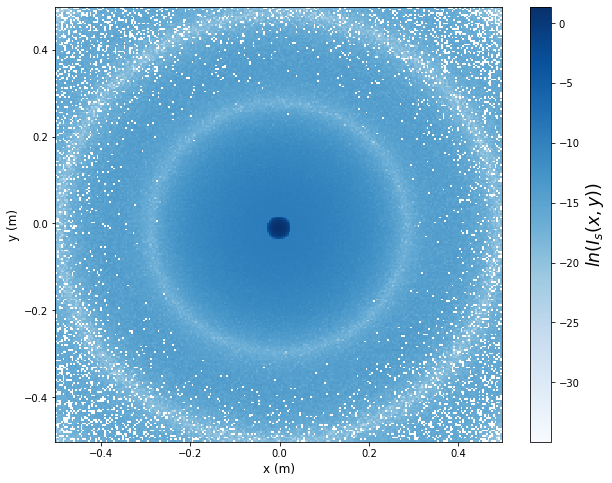

In [8]:
model.scatterplot()

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/3302440058.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\


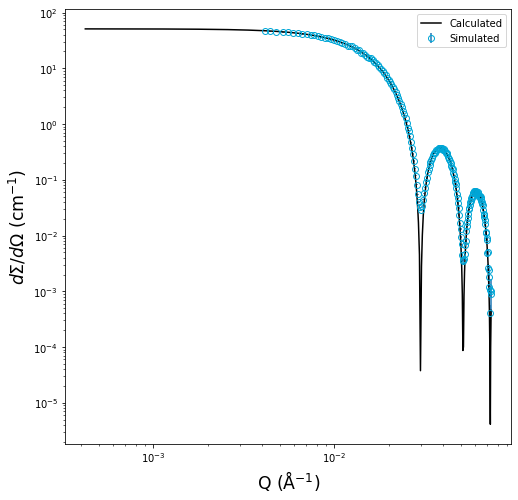

In [9]:
q_1, I_1, I_err_1, _ =  model.intensity_plot(scale = 1, plot = True, throw_away = 11)

In [10]:
model2 = monochromatic(lambda0 = 3, pos_sample = 9, L = 12, beamstop = False, incoherent_bg = 0,\
                      sample_type = 'SANS_spheres2', detector_size = 1, pixels = 249)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data5"
INFO: Regenerating c-file: Monochromatic.c
CFLAGS=
INFO: Recompiling: Monochromatic.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy Monochromatic.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data5

Instrument parameters for Monochromatic (Monochromatic.instr)
Detector: Monitor1_I=171.481 Monitor1_ERR=0.0873004 Monitor1_N=3.85833e+006 "Monitor1"
Detector: Monitor2_I=171.579 Monitor2_ERR=0.195123 Monitor2_N=3.70106e+006 "Monitor2"
Detector: PSD_I=171.578 PSD_ERR=0.195123 PSD_N=3.02964e+006 "PSD.dat"

The component named "Monitor1" had no data file and will not be loaded.
The component named "Monitor2" had no data file a

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/2104454623.py:54: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')


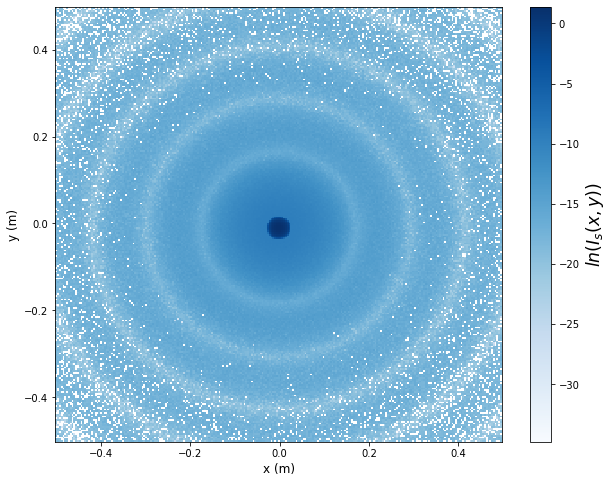

In [11]:
model2.scatterplot()

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/3302440058.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\


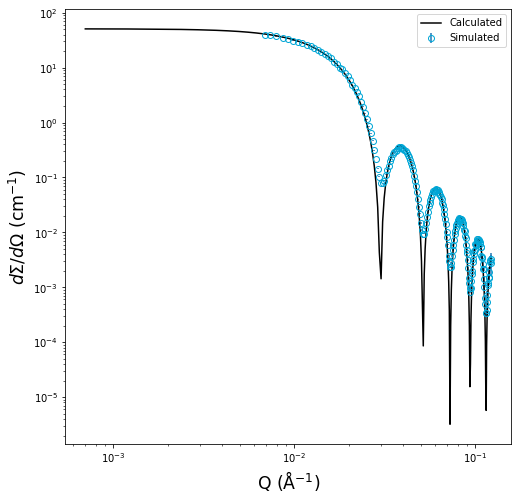

In [12]:
q_2, I_2, I_err_2, _ =  model2.intensity_plot(scale = 1, plot = True, throw_away = 11)

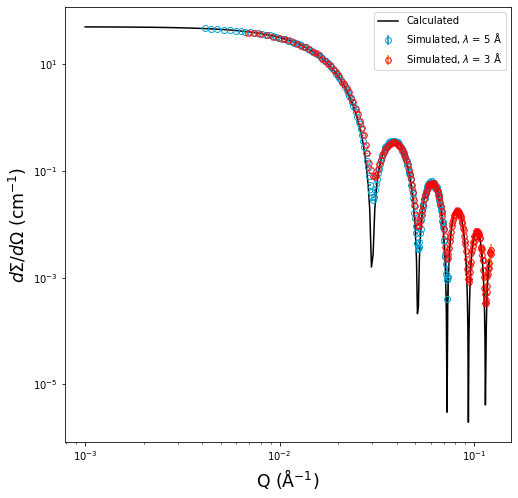

In [13]:
q_range = np.linspace(0.001, 0.12, 200)
I_cal = spheres(q_range*1e8, 150*1e-8, 1e-3, 6e10, 0)
plt.figure(figsize = (8,8))
plt.errorbar(q_1, I_1, yerr = I_err_1, marker = 'o', mec=tu_delft_cyan, mew = 1,\
             fillstyle = 'none', linestyle = 'None', label = 'Simulated, $\lambda$ = 5 Å')
plt.errorbar(q_2, I_2, yerr = I_err_2, marker = 'H', mec=(1,0,0,0.8), fillstyle = 'none',\
             mew = 1.3, linestyle = 'None', label = 'Simulated, $\lambda$ = 3 Å')
plt.plot(q_range, I_cal, label = 'Calculated', color = (0,0,0))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q (Å$^{-1}$)', size = 'xx-large')
plt.ylabel('$d\\Sigma / d\\Omega$ (cm$^{-1}$)', size = 'xx-large')
plt.legend()
plt.show()

In [14]:
model3 = monochromatic(lambda0 = 5, pos_sample = 9, L = 12, beamstop = False, incoherent_bg = 0.5,\
                      sample_type = 'SANS_spheres2', detector_size = 1, pixels = 249)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data6"
INFO: Regenerating c-file: Monochromatic.c
CFLAGS=
INFO: Recompiling: Monochromatic.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy Monochromatic.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data6

Instrument parameters for Monochromatic (Monochromatic.instr)
Detector: Monitor1_I=171.395 Monitor1_ERR=0.0872786 Monitor1_N=3.8564e+006 "Monitor1"
Detector: Monitor2_I=131.565 Monitor2_ERR=0.135797 Monitor2_N=3.78388e+006 "Monitor2"
Detector: PSD_I=91.5477 PSD_ERR=0.103905 PSD_N=3.06862e+006 "PSD.dat"

The component named "Monitor1" had no data file and will not be loaded.
The component named "Monitor2" had no data file an

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/2104454623.py:54: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')


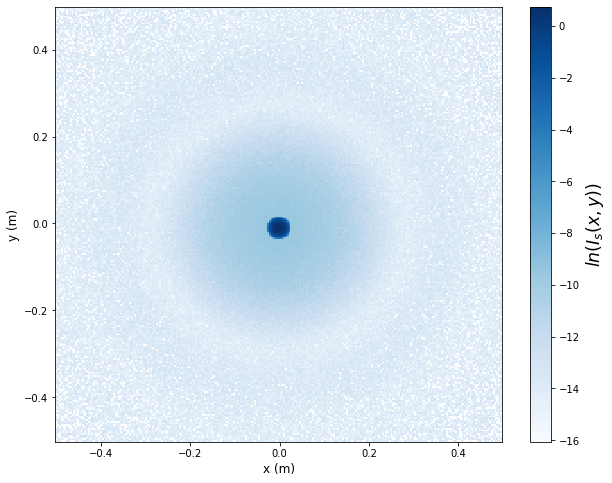

In [15]:
model3.scatterplot()

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/3302440058.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\


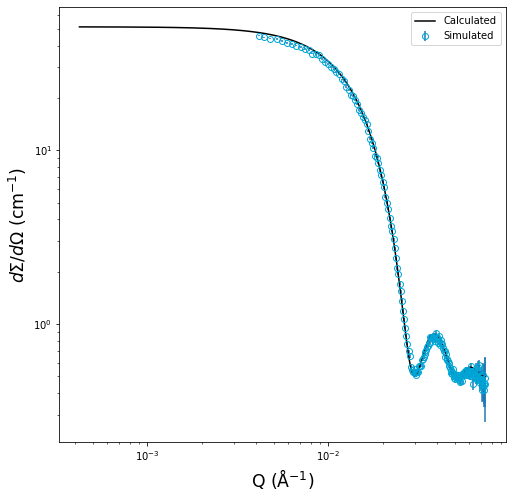

In [16]:
q_1, I_1, I_err_1, _ =  model3.intensity_plot(scale = 1, plot = True, throw_away = 11)

In [17]:
model4 = monochromatic(lambda0 = 3, pos_sample = 9, L = 12, beamstop = False, incoherent_bg = 0.5,\
                      sample_type = 'SANS_spheres2', detector_size = 1, pixels = 249)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data7"
INFO: Regenerating c-file: Monochromatic.c
CFLAGS=
INFO: Recompiling: Monochromatic.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy Monochromatic.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data7

Instrument parameters for Monochromatic (Monochromatic.instr)
Detector: Monitor1_I=171.462 Monitor1_ERR=0.0872957 Monitor1_N=3.85791e+006 "Monitor1"
Detector: Monitor2_I=131.509 Monitor2_ERR=0.137706 Monitor2_N=3.70057e+006 "Monitor2"
Detector: PSD_I=91.5671 PSD_ERR=0.104075 PSD_N=3.02887e+006 "PSD.dat"

The component named "Monitor1" had no data file and will not be loaded.
The component named "Monitor2" had no data file a

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/2104454623.py:54: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(x, y, np.log(self.I_data), cmap='Blues', shading='auto')


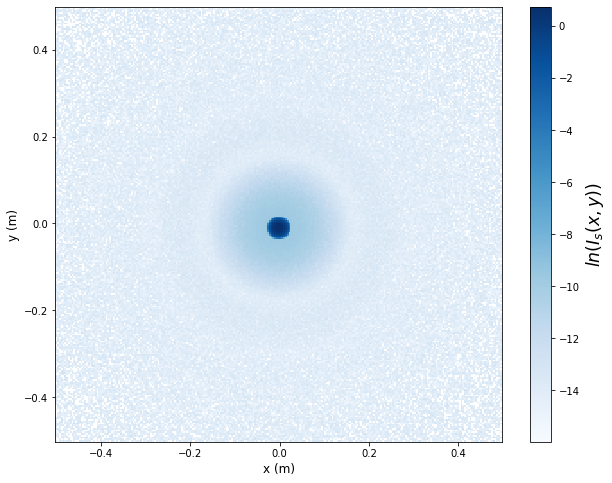

In [18]:
model4.scatterplot()

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/3302440058.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\


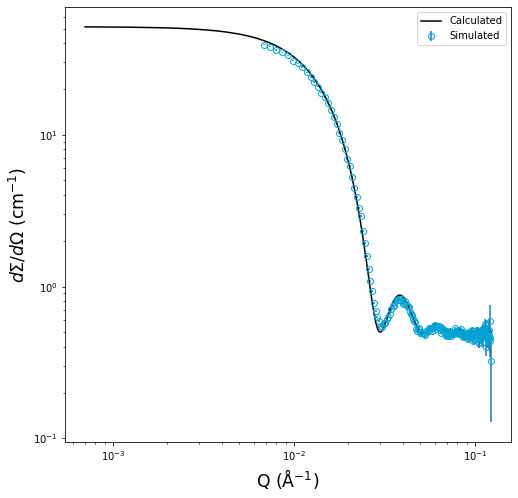

In [19]:
q_2, I_2, I_err_2, _ =  model4.intensity_plot(scale = 1, plot = True, throw_away = 11)

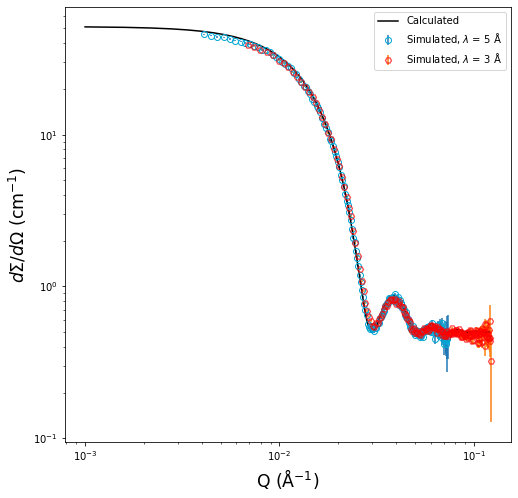

In [20]:
q_range = np.linspace(0.001, 0.12, 200)
I_cal = spheres(q_range*1e8, 150*1e-8, 1e-3, 6e10, 0.5)
plt.figure(figsize = (8,8))
plt.errorbar(q_1, I_1, yerr = I_err_1, marker = 'o', mec=tu_delft_cyan, mew = 1,\
             fillstyle = 'none', linestyle = 'None', label = 'Simulated, $\lambda$ = 5 Å')
plt.errorbar(q_2, I_2, yerr = I_err_2, marker = 'H', mec=(1,0,0,0.7), fillstyle = 'none',\
             mew = 1.3, linestyle = 'None', label = 'Simulated, $\lambda$ = 3 Å')
plt.plot(q_range, I_cal, label = 'Calculated', color = (0,0,0))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q (Å$^{-1}$)', size = 'xx-large')
plt.ylabel('$d\\Sigma / d\\Omega$ (cm$^{-1}$)', size = 'xx-large')
plt.legend()
plt.show()

<h2>TOF SANS</h2>

In [21]:
def TOF_model(L_min, L_max, N_counts, min_t_PSD, max_t_PSD, pos_sample = 6.2, L=6.3, pos_slit1=3, radius = 150, \
       incoherent_bg = 0, d = 0.001, pixels = 249, beamstop = True, sample_type = 'SANS_spheres2',\
       sc_aim = 0.8, sans_aim = 0.95, detector_size = 2, ncounts = 1e8):
    """model to run time of flight setup"""
    
    pos_slit2 = pos_sample - 0.2
    pos_monitor1 = pos_sample - 0.001
    pos_monitor2 = pos_sample + 0.001
    pos_PSD = pos_sample + L
    pos_beamstop = pos_PSD - 0.001
    slit_radius = 0.005
    
    h = 6.626e-34 #Js (Planck's constant)
    m = 1.675e-27 #kg (Neutron mass)
    
    #function to get wavelength as function of time t and position z
    wavelength = lambda t, z: (h*t*1e-6 / (m*z)) * 1e10 #AA
    
    #get min and max wavelength calculated at PSD postion
    min_mon = wavelength(min_t_PSD, pos_PSD)
    max_mon = wavelength(max_t_PSD, pos_PSD) 
    
    Instrument = instr.McStas_instr('TOF_test')
    
    #add in source
    Source = Instrument.add_component('Source', 'Source_gen')
    Source.Lmin = L_min #AA
    Source.Lmax = L_max #AA
    Source.radius = 0.07
    Source.focus_xw = 0.01 #m
    Source.focus_yh = 0.01 #m
    Source.dist = pos_sample
    
    #add in slits
    Slit1 = Instrument.add_component('Slit1', 'Slit', AT = [0,0,pos_slit1], RELATIVE = 'Source')
    Slit1.radius = slit_radius
    
    Slit2 = Instrument.add_component('Slit2', 'Slit', AT = [0,0,pos_slit2], RELATIVE = 'Source')
    Slit2.radius = slit_radius 
    
    #monitor 1
    Monitor1 = Instrument.add_component('Monitor1', 'L_monitor', AT = [0,0,pos_monitor1],RELATIVE = 'Source')
    Monitor1.xwidth = detector_size #m
    Monitor1.yheight = detector_size #m
    Monitor1.Lmin = min_mon
    Monitor1.Lmax = max_mon
    Monitor1.nL = N_counts
    Monitor1.filename = "\"Monitor1\""
    Monitor1.restore_neutron = 1
    
    #add in sample
    if sample_type == 'SANS_spheres2':
        Sample = Instrument.add_component('Sample', 'SANS_spheres2', AT = [0,0,pos_sample],RELATIVE='Source')
        Sample.xwidth = 0.01 #m
        Sample.yheight = 0.01 #m
        Sample.zthick = d #m
        Sample.R = radius #AA 
        Sample.phi = 1e-3
        Sample.dsdw_inc = incoherent_bg #cm^-1
        Sample.drho = 6e10 #cm^-2
        Sample.Qmind = 0.0001 
        Sample.Qmaxd = 3
        Sample.sc_aim = sc_aim
        Sample.sans_aim = sans_aim
    elif sample_type == 'SANS_spheres':
        Sample = Instrument.add_component('Sample', 'Sans_spheres', AT = [0,0,pos_sample],\
                                      RELATIVE='Source')
        Sample.xwidth = 0.01 #m
        Sample.yheight = 0.01 #m
        Sample.zdepth = d #m
        Sample.R = radius #AA 
        Sample.Phi = 1e-3
        Sample.focus_xw = 2 #m
        Sample.focus_yh = 2 #m
        Sample.target_z = L
    elif sample_type == 'None':
        pass
    else: 
        raise TypeError('Please enter a valid sample type')
    
    #monitor 2
    Monitor2 = Instrument.add_component('Monitor2', 'L_monitor', AT = [0,0,pos_monitor2],RELATIVE = 'Source')
    Monitor2.xwidth = detector_size #m
    Monitor2.yheight = detector_size #m
    Monitor2.Lmin = min_mon
    Monitor2.Lmax = max_mon
    Monitor2.nL = N_counts
    Monitor2.filename = "\"Monitor2\""
    Monitor2.restore_neutron = 1
    
    #add beamstop if wanted
    if beamstop: 
        Beamstop = Instrument.add_component('Beamstop', 'Beamstop', AT = [0,0,pos_beamstop],\
                                        RELATIVE = 'Source')
        Beamstop.radius = 0.08 #m
    
    #add PSD
    PSD = Instrument.add_component('PSD', 'PSD_TOF_monitor', AT=[0,0,pos_PSD],RELATIVE='Source')
    PSD.xwidth = detector_size #m
    PSD.yheight = detector_size #m 
    PSD.nx = 249
    PSD.ny = 249
    PSD.nt = N_counts
    PSD.tmin = min_t_PSD #mus
    PSD.tmax = max_t_PSD #mus
    PSD.restore_neutron = 0
    PSD.filename = "\"PSD\""
    
    data = Instrument.run_full_instrument(foldername = 'tof_sans\\data', nmpi=6,\
                                          ncount=ncounts, increment_folder_name = True)
    
    monitor1_data = functions.name_search("Monitor1", data)
    monitor2_data = functions.name_search("Monitor2", data)
    
    PSD_data = functions.name_search("PSD", data)
    
    monitor1_result = [monitor1_data.xaxis, monitor1_data.Intensity, monitor1_data.Error]
    monitor2_result = [monitor2_data.xaxis, monitor2_data.Intensity, monitor2_data.Error]
    
    t_PSD = np.linspace(min_t_PSD, max_t_PSD, N_counts)
    lambda_PSD = wavelength(t_PSD, pos_PSD)
    
    I_PSD = []
    err_PSD = []
    for PSD in PSD_data:
        I_PSD.append(PSD.Intensity)
        err_PSD.append(PSD.Error)
        
    PSD_result = [lambda_PSD, np.array(I_PSD)[1:], np.array(err_PSD)[1:]]
    
    return monitor1_result, monitor2_result, PSD_result

In [22]:
class TOF(object):
    def __init__(self, L_min, L_max, N_counts, min_t_PSD, max_t_PSD, pos_sample = 6.2, L=6.3,\
                 pos_slit1=3, radius = 150, incoherent_bg = 0, d = 0.001, pixels = 249, beamstop = True,\
                 sample_type = 'SANS_spheres2', sc_aim = 0.8, sans_aim = 0.95, detector_size = 2, ncounts = 1e8):
        #load in results of simulation
        self.monitor1, self.monitor2, self.PSD = TOF_model(L_min, L_max, N_counts, min_t_PSD, max_t_PSD,\
                                                           pos_sample, L, pos_slit1, radius, incoherent_bg,\
                                                           d, pixels, beamstop, sample_type, sc_aim, sans_aim,\
                                                           detector_size, ncounts)
        #load in parameters
        self.L_min = L_min #AA
        self.L_max = L_max #AA
        self.N_counts = N_counts
        self.L = L
        self.d = d
        self.detector_size = detector_size
        self.pixels = pixels
        self.p_x = detector_size/self.pixels #m
        self.radius = radius #AA
        self.incoherent_bg = incoherent_bg #cm^(-1)
        
        #create a grid with all distances to center of PSD
        y, x = np.ogrid[0:self.pixels, 0:self.pixels]
        self.dist = self.p_x * np.sqrt((y-int(self.pixels/2))**2 + (x-int(self.pixels/2))**2) #m 
        #the angle for each pixel of PSD
        self.two_theta = np.arctan(self.dist/self.L)
        
    def lambda_plot_PSD(self):
        """Plot the integrated PSD intensities as function of wavelength"""
        wl_PSD = self.PSD[0]
        I_PSD = []
        for PSD in self.PSD[1]: 
            I_PSD.append(np.sum(PSD))
        
        plt.figure(figsize = (8,8))
        plt.plot(wl_PSD, I_PSD, marker = 'o', label = 'Integrated PSD data')
        plt.vlines(x = self.L_min, ymin = 0, ymax = np.max(I_PSD)*1.1, color = 'red')
        plt.vlines(x = self.L_max, ymin = 0, ymax = np.max(I_PSD)*1.1, color = 'red')
        plt.xlabel('wavelength (AA)', size = 'x-large')
        plt.ylabel('Intensity (au)', size = 'x-large')
        plt.legend()
        plt.show()
    
    def lambda_plot_mon(self):
        """Plot the monitor intensities as function of wavelength"""
        wl_mon1, I_mon1 = self.monitor1[0], self.monitor1[1]
        wl_mon2, I_mon2 = self.monitor2[0], self.monitor2[1]
        plt.figure(figsize = (8,8))
        plt.plot(wl_mon1, I_mon1, marker = 'o', label = '$I_0$')
        plt.plot(wl_mon2, I_mon2, marker = 'o', label = '$I_1$')
        plt.vlines(x = self.L_min, ymin = 0, ymax = np.max(I_mon1)*1.1, color = 'red')
        plt.vlines(x = self.L_max, ymin = 0, ymax = np.max(I_mon1)*1.1, color = 'red')
        plt.xlabel('wavelength (AA)', size = 'x-large')
        plt.ylabel('Intensity (au)', size = 'x-large')
        plt.legend()
        plt.show()

    def I_0_lambda(self, wavelength, error = False):
        """linearly interpolate monitor 1 data to get I_0 over full lambda range"""
        wl, I_0 = self.monitor1[0], self.monitor1[1]
        I_0_func = interp1d(wl, I_0)
        if error: 
            I_0_err = self.monitor1[2]
            I_0_err_func = interp1d(wl, I_0_err)
            return I_0_func(wavelength), I_0_err_func(wavelength)
        return I_0_func(wavelength)
    
    def T_lambda(self, wavelength, error = False):
        """linearly interpolate I_0 and I_1 data to get T over full lambda range"""
        wl, I_1 = self.monitor2[0], self.monitor2[1]
        I_1_func = interp1d(wl, I_1)
        T = I_1_func(wavelength) / self.I_0_lambda(wavelength)
        if error:
            I_0, I_0_err = self.I_0_lambda(wavelength, error = True)
            I_1_err = self.monitor2[2]
            I_1_err_func = interp1d(wl, I_1_err)
            T_err = np.sqrt((I_1_err_func(wavelength)/I_0)**2\
                           + ((I_1_func(wavelength)*I_0_err)/I_0**2)**2)
            return T, T_err
        return T
    
    def plot_T(self):
        """Plot transmission as a function of wavelength"""
        lambdas, I_0, I_0_err = self.monitor1[0], self.monitor1[1], self.monitor1[2]
        ind = np.where(np.logical_and(lambdas > self.L_min, lambdas < self.L_max))
        lambdas, I_0, I_0_err = lambdas[ind], I_0[ind], I_0_err[ind]
        I_1, I_1_err = self.monitor2[1][ind], self.monitor2[2][ind]
        T = I_1/I_0
        T_err = np.sqrt((I_1_err/I_0)**2 + ((I_1*I_0_err)/I_0**2)**2)
        plt.figure(figsize = (8,8))
        plt.errorbar(lambdas, T, yerr = T_err, marker = 'o',\
                     linestyle = 'None', color = tu_delft_cyan)
        plt.hlines(y = 1, xmin = self.L_min, xmax = self.L_max, linestyle = 'dashed', color = (0,0,0))
        plt.ylabel('T', size = 'xx-large')
        plt.xlabel('wavelength (Å)', size = 'xx-large')
        plt.show()
        
    def absolute_calibration(self, index, error = False):
        """Do the absolute calibration for a given PSD snapshot"""
        wavelength = self.PSD[0][index]
        domega = ((self.p_x/self.L)**2)*np.cos(self.two_theta)**3
        d = self.d *100 #cm (convert from m to cm)
        if error:
            I_0, I_0_err = self.I_0_lambda(wavelength, error = True)
            T, T_err = self.T_lambda(wavelength, error = True)
            part_1 = (self.PSD[1][index]/(I_0*T*d*domega))**2
            part_2 = (self.PSD[1][index]*I_0_err/(I_0**2*T*d*domega))**2
            part_3 = (self.PSD[1][index]*T_err/(I_0*T**2*d*domega))**2
            err = np.sqrt(part_1 + part_2 + part_3)
            return self.PSD[1][index]/(I_0 * T * domega * d), err
        I_0 = self.I_0_lambda(wavelength)
        T = self.T_lambda(wavelength, error = False)
        return self.PSD[1][index]/(I_0 * T * domega * d)
          
    def intensity_plot_q(self, index, scale = 1, plot = False):
        """Plot I vs Q for each pixel for a given snapshot index"""
        #get wavelength corresponding to each PSD "snapshot"
        wavelength = self.PSD[0][index]
        if wavelength < self.L_min or wavelength > self.L_max: 
            raise ValueError("The given PSD index does not lie within the wavelength range and thus cannot be considered")
        q = 4*np.pi*np.sin(self.two_theta/2)/wavelength
        #get intensity and q sorted by q value
        q_sorted_indices = np.argsort(q.flat)
        I_q, I_q_err = self.absolute_calibration(index, error = True)
        I_q = I_q.flat[q_sorted_indices]
        I_q_err = I_q_err.flat[q_sorted_indices]
        q_sorted = q.flat[q_sorted_indices]
        q_sorted_unique, q_index, q_counts = np.unique(q_sorted, \
                                                       return_index = True, \
                                                       return_counts = True)
        I_q_avg, I_q_avg_err = get_q_profile(q_index, q_counts, I_q, I_q_err)
        I_q_avg, I_q_avg_err = np.array(I_q_avg), np.array(I_q_avg_err)
        if plot: 
            I_calculated = spheres(q_sorted_unique*1e8, self.radius*1e-8, 1e-3, 6e10, self.incoherent_bg) #cm^(-1)
            plt.figure(figsize = (8,8))
            plt.errorbar(q_sorted_unique, I_q_avg*scale, yerr = I_q_avg_err, \
                         marker = 'o', linestyle = 'None', label = 'simulated')
            plt.plot(q_sorted_unique, I_calculated, label = 'calculated')
            plt.yscale('log')
            plt.xscale('log')
            plt.xlabel('Q (AA^-1)')
            plt.ylabel('Intensity (cm^-1)', size = 'large')
            plt.title(f"Intensity versus q for $\lambda$ = {wavelength.round(2)} Å",\
                      size = 'large')
            plt.legend()
            plt.show()
        return I_q_avg, I_q_avg_err, q_sorted_unique
    
    def intensity_plot(self, scale, throw_away = 0, bins = 50, plot = True):
        """Get the final plot to match against theory"""
        #empty arrays to store results
        I_q = []
        I_q_err = []
        q = []
        #put everything in I_q and q
        for index, wavelength in enumerate(self.PSD[0]):
            if wavelength > self.L_min and wavelength < self.L_max: 
                I_q_i, I_q_i_err, q_i = self.intensity_plot_q(index)
                I_q.append(I_q_i)
                I_q_err.append(I_q_i_err)
                q.append(q_i)
        I_q = np.array(I_q)
        I_q_err = np.array(I_q_err)
        q = np.array(q)
        #sort everything by q value
        sorted_ind = np.argsort(q.flatten())
        q = q.flatten()[sorted_ind]
        I_q = I_q.flatten()[sorted_ind]
        I_q_err = I_q_err.flatten()[sorted_ind]
        #bin the data equally spaced in bins number of bins within q_range
        q_binned, I_binned, I_binned_err = binning(q, I_q, I_q_err, bins)
        I_calculated = spheres(q_binned*1e8, self.radius*1e-8, 1e-3, 6e10, self.incoherent_bg)
        #plot 
        if plot: 
            plt.figure(figsize = (8,8))
            plt.errorbar(q_binned[throw_away:], I_binned[throw_away:] * scale, yerr = I_binned_err[throw_away:], \
                         marker = 'o', mec = tu_delft_cyan, fillstyle = 'none', \
                         mew = 1, linestyle = 'None', label = 'simulated')
            plt.plot(q_binned, I_calculated, label = 'calculated', color = (0,0,0))
            plt.yscale('log')
            plt.xscale('log')
            plt.legend()
            plt.xlabel('$Q$ (Å$^{-1}$)', size = 'xx-large')
            plt.ylabel('$d\\Sigma / d\\Omega$ (cm$^{-1}$)', size = 'xx-large')
            plt.show()
        return q_binned[throw_away:], I_binned[throw_away:], I_binned_err[throw_away:]

In [23]:
model_tof = TOF(3, 6, 20, 10000, 25000, beamstop = False, pos_sample = 6, L = 9, ncounts = 1e9, detector_size = 1)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_2"
INFO: Regenerating c-file: TOF_test.c
CFLAGS=
INFO: Recompiling: TOF_test.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy TOF_test.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_2

Instrument parameters for TOF_test (TOF_test.instr)
Detector: Monitor1_I=2.25491e-005 Monitor1_ERR=5.3783e-009 Monitor1_N=1.75779e+007 "Monitor1.dat"
Detector: Monitor2_I=2.25492e-005 Monitor2_ERR=1.20059e-008 Monitor2_N=1.69217e+007 "Monitor2.dat"
Detector: PSD_I=2.25489e-005 PSD_ERR=1.20059e-008 PSD_N=1.26852e+007 "PSD_Sum.dat"
Detector: PSD_I=0 PSD_ERR=0 PSD_N=0 "PSD_0.dat"
Detector: PSD_I=2.45902e-007 PSD_ERR=1.25495e-009 PSD_N=138933 "PSD_1.dat"
Detec

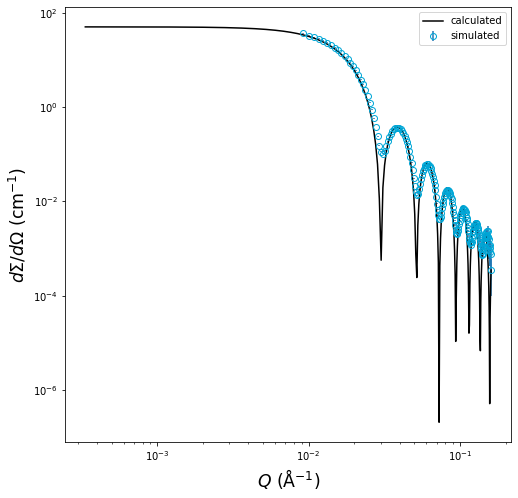

In [24]:
_, _, _ = model_tof.intensity_plot(scale = 1, bins = 200, throw_away = 11)

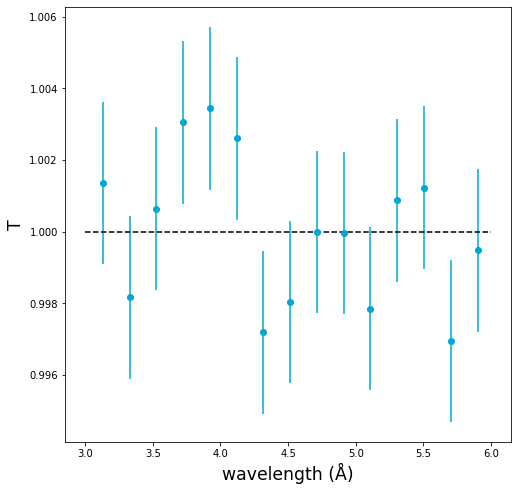

In [25]:
model_tof.plot_T()

In [26]:
model_tof_bg = TOF(3, 6, 20, 10000, 25000, beamstop = False, pos_sample = 6, L = 9, ncounts = 1e9, detector_size = 1, \
               incoherent_bg = 0.5)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_3"
INFO: Regenerating c-file: TOF_test.c
CFLAGS=
INFO: Recompiling: TOF_test.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy TOF_test.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_3

Instrument parameters for TOF_test (TOF_test.instr)
Detector: Monitor1_I=2.25427e-005 Monitor1_ERR=5.37755e-009 Monitor1_N=1.75729e+007 "Monitor1.dat"
Detector: Monitor2_I=1.72785e-005 Monitor2_ERR=7.83288e-009 Monitor2_N=1.69165e+007 "Monitor2.dat"
Detector: PSD_I=1.20439e-005 PSD_ERR=6.40407e-009 PSD_N=1.26837e+007 "PSD_Sum.dat"
Detector: PSD_I=0 PSD_ERR=0 PSD_N=0 "PSD_0.dat"
Detector: PSD_I=1.33686e-007 PSD_ERR=6.75495e-010 PSD_N=140602 "PSD_1.dat"
Dete

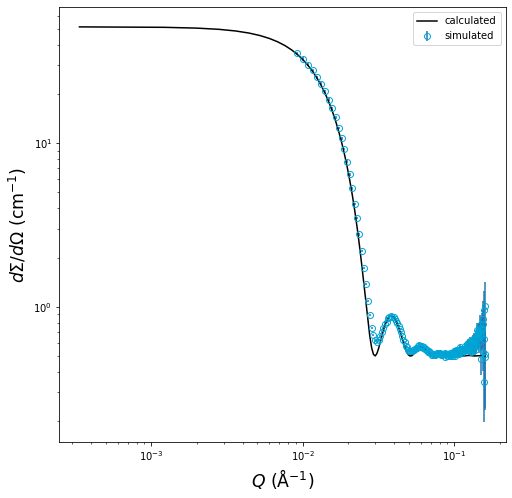

In [27]:
_, _, _ = model_tof_bg.intensity_plot(scale = 1, bins = 200, throw_away = 11)

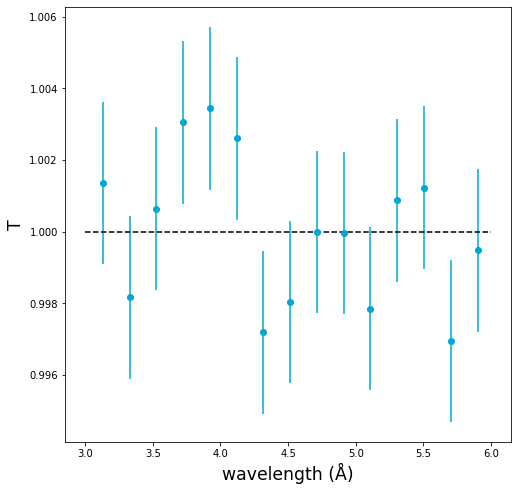

In [28]:
model_tof.plot_T()

In [29]:
model_tof_bg2 = TOF(3, 6, 20, 10000, 25000, beamstop = False, pos_sample = 6, L = 9, ncounts = 1e8, detector_size = 1, \
               incoherent_bg = 1)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_4"
INFO: Regenerating c-file: TOF_test.c
CFLAGS=
INFO: Recompiling: TOF_test.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy TOF_test.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\tof_sans\data_4

Instrument parameters for TOF_test (TOF_test.instr)
Detector: Monitor1_I=2.25695e-005 Monitor1_ERR=1.70154e-008 Monitor1_N=1.75938e+006 "Monitor1.dat"
Detector: Monitor2_I=1.44586e-005 Monitor2_ERR=2.43799e-008 Monitor2_N=1.69355e+006 "Monitor2.dat"
Detector: PSD_I=6.44913e-006 PSD_ERR=1.08102e-008 PSD_N=1.27015e+006 "PSD_Sum.dat"
Detector: PSD_I=0 PSD_ERR=0 PSD_N=0 "PSD_0.dat"
Detector: PSD_I=7.06142e-008 PSD_ERR=1.13295e-009 PSD_N=14037 "PSD_1.dat"
Detec

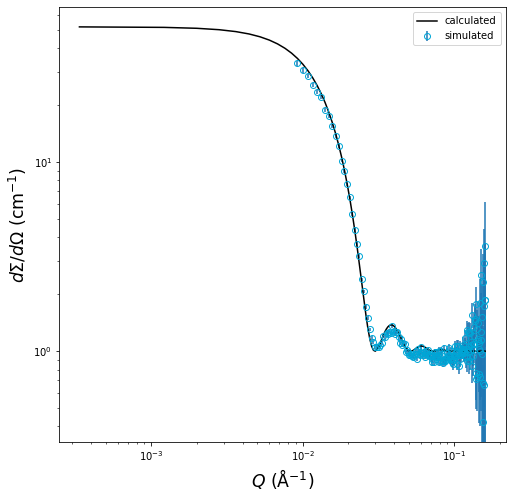

In [30]:
_, _, _ = model_tof_bg2.intensity_plot(scale = 1, bins = 200, throw_away = 11)

<h2>Miniature monochromatic SANS</h2>

In [31]:
miniature = monochromatic(radius = 10000, qmin = 0.000003, qmax = 0.1, lambda0 = 5, pos_sample = 3,\
                       L = 3, beamstop = False, incoherent_bg = 0,sample_type = 'SANS_spheres2',\
                       beamsize = 0.0003, detector_size = 0.011, pixels = 129, pos_slit1 = 0.5, \
                        focus_size = 0.0001, ncounts = 1e9)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data8"
INFO: Regenerating c-file: Monochromatic.c
CFLAGS=
INFO: Recompiling: Monochromatic.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy Monochromatic.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\monochromatic_sans\data8

Instrument parameters for Monochromatic (Monochromatic.instr)
Detector: Monitor1_I=0.000452672 Monitor1_ERR=1.34562e-006 Monitor1_N=113168 "Monitor1"
Detector: Monitor2_I=0.000476327 Monitor2_ERR=2.71663e-006 Monitor2_N=110816 "Monitor2"
Detector: PSD_I=0.000448652 PSD_ERR=2.65184e-006 PSD_N=78410 "PSD.dat"

The component named "Monitor1" had no data file and will not be loaded.
The component named "Monitor2" had no data fi

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/3302440058.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (3 * V * delta_rho *(np.sin(Q*r) - Q * r * np.cos(Q*r)) / ((Q*r)**3) )**2\


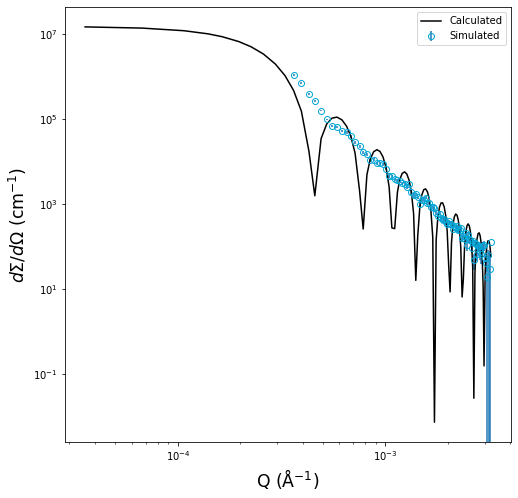

In [32]:
_,_,_,_ =  miniature.intensity_plot(scale = 1, plot = True, throw_away = 11, N_bins = 100)

Miniature has very low resolution but works...

<h1> SESANS </h1>

In [33]:
def gz_sphere_PY(z,R):
#Simple sphere G(z) Analytical function from Krugolov paper eqn 32
#Krugolov 2005 Real space interpretation of spin echo small angle neutron
#scattering, Paper 2003 in Journal of applied crystallography NOT the Andersoon
#paper which apears to be wrong (as usual some things are not quite correct).
    zor=z/R
    if z > 2*R:
        return 0.0
    else:
        return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))
gz_sphere_PY=np.vectorize(gz_sphere_PY)

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: divide by zero encountered in log
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))
C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))


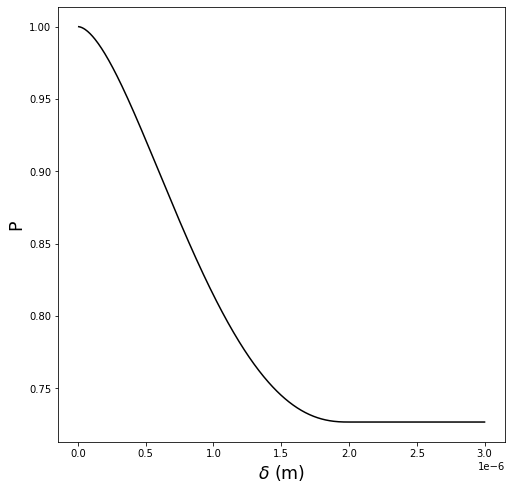

In [34]:
deltas = np.linspace(0,3e-6,500)
phi = 0.015
drho = 6e14
wavelength = 2e-10
d = 0.001
r = 1e-6
tau = (3/2)*phi*(1-phi)*(drho**2)*(wavelength**2)*d*r
P = np.exp(tau*(gz_sphere_PY(deltas, r) - 1))
plt.figure(figsize = (8,8))
plt.plot(deltas, P, color = (0,0,0))
plt.xlabel('$\delta$ (m)', size = 'xx-large' )
plt.ylabel('P', size = 'xx-large')
plt.show()

<h2>Monochromatic SESANS</h2>

In [35]:
def SESANS_model(analyser, B_prisms, lambda0 = 2.165, radius = 1e-6, pos_polarizer = 0.1,\
                 pos_prism1 = 0.5, dist_between_prisms = 2, dist_prism_sample = 0.2, pos_detector = 5,\
                 phi = 0.015, drho = 6e10, d = 1e-3, foldername = 'data', incoherent_bg = 0, ncounts = 1e4): 
    """Create SESANS mcstas model. All dimensions are in m, wavelenght in AA and B in T.\
    For positive values of polarization I+ is measured, for negative ones I-"""
    if analyser >= 0: 
        analyser = 1
    elif analyser < 0: 
        analyser = -1
    Instrument = instr.McStas_instr('SESANS')
    
    pos_prism2 = pos_prism1 + dist_between_prisms
    pos_sample = pos_prism2 + dist_prism_sample
    pos_slit = pos_sample - 0.01
    pos_prism3 = pos_sample + dist_prism_sample
    pos_prism4 = pos_prism3 + dist_between_prisms
    pos_analyser = pos_detector - 0.01
    
    prism_x = 85e-3
    prism_y = 35e-3
    
    #adding the source
    Source = Instrument.add_component('Source', 'Source_simple') 
    Source.xwidth = 0.01 #m
    Source.yheight = 0.01 #m
    Source.focus_xw = 0.01 #m
    Source.focus_yh = 0.01 #m
    Source.lambda0 = lambda0 #AA
    Source.dist = pos_detector
    Source.flux = 1e8
    
    #adding the polarizer
    Polarizer = Instrument.add_component('Polarizer', 'Set_pol', AT = [0,0,pos_polarizer], RELATIVE = 'Source')
    Polarizer.px = 1
    Polarizer.py = 0
    Polarizer.pz = 0
    Polarizer.normalize = 0
    
    #adding first two prisms
    Prism1 = Instrument.add_component('Prism1', 'Pol_WollatonPrism', AT = [0,0,pos_prism1-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism1.xwidth = prism_x #m
    Prism1.yheight = prism_y #m
    Prism1.zdepth = prism_x #m
    Prism1.Current = B_prisms/(30*1e-4) # 30 G/A
    
    Prism2 = Instrument.add_component('Prism2', 'Pol_WollatonPrism', AT = [0,0,pos_prism2-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism2.xwidth = prism_x #m
    Prism2.yheight = prism_y #m
    Prism2.zdepth = prism_x #m
    Prism2.Current = -B_prisms/(30*1e-4)
    
    
    #adding sample
    Sample = Instrument.add_component('Sample', 'SANS_spheres2', AT = [0,0,pos_sample],\
                                          RELATIVE='Source')
    Sample.xwidth = 0.02 #m
    Sample.yheight = 0.02 #m
    Sample.zthick = d #m
    Sample.R = radius*1e10 #AA 
    Sample.phi = phi
    Sample.dsdw_inc = incoherent_bg #cm^-1
    Sample.drho = drho #cm^-2
    Sample.Qmind = 0.000003
    Sample.Qmaxd = 0.001
    Sample.sc_aim = 0.8
    Sample.sans_aim = 0.95
    Sample.singlesp = 0
    
    #adding second two prisms
    Prism3 = Instrument.add_component('Prism3', 'Pol_WollatonPrism', AT = [0,0,pos_prism3-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism3.xwidth = prism_x #m
    Prism3.yheight = prism_y #m
    Prism3.zdepth = prism_x #m
    Prism3.Current = -B_prisms/(30*1e-4)
    
    Prism4 = Instrument.add_component('Prism4', 'Pol_WollatonPrism', AT = [0,0,pos_prism4-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism4.xwidth = prism_x #m
    Prism4.yheight = prism_y #m
    Prism4.zdepth = prism_x #m
    Prism4.Current = B_prisms/(30*1e-4)
    
    #add analyser
    Analyser = Instrument.add_component('Analyser', 'PolAnalyser_ideal', AT = [0,0,pos_analyser], RELATIVE = 'Source')
    Analyser.mx = analyser
    Analyser.my = 0
    Analyser.mz = 0
    
    #add monitor
    Monitor = Instrument.add_component('Monitor', 'PSD_monitor', AT = [0,0,pos_detector],RELATIVE = 'Source')
    Monitor.xwidth = 0.11 #m
    Monitor.yheight = 0.11 #m
    Monitor.ny = 1001
    Monitor.nx = 1
    Monitor.filename = "\"PSD\""
    
    data = Instrument.run_full_instrument(foldername = foldername, nmpi=6,\
                                          ncount=ncounts, increment_folder_name = True)
    
    monitor_data = functions.name_search("Monitor", data)
    return np.sum(monitor_data.Intensity), np.sqrt(np.sum(monitor_data.Error**2))

In [36]:
class SESANS(object): 
    def __init__(self, B_range, N_B, lambda0 = 2.165, radius = 1e-6, pos_polarizer = 0.1,\
                 pos_prism1 = 0.5, dist_between_prisms = 1.5, dist_prism_sample = 0.25, pos_detector = 4.5,\
                phi = 0.015, drho = 6e10, d = 1e-3, foldername = "sesans\\data", incoherent_bg = 0, ncounts = 1e4):
        """SESANS model, B_range is a tuple in T. Runs the SESANS_model() N_B times within B_range,\
        measuring both the intensity of the positive and negative polarized neutrons"""
        B_min, B_max = B_range
        Bs = np.linspace(B_min, B_max, N_B)
        I_plus = []
        I_min = []
        I_plus_err = []
        I_min_err = []
        start_time = time.time()
        for B in Bs:
            I_plus_B, I_plus_B_err = SESANS_model(1, B, lambda0, radius, pos_polarizer, pos_prism1,\
                                                  dist_between_prisms, dist_prism_sample, pos_detector,\
                                                  phi, drho, d, foldername, incoherent_bg, ncounts)
            I_min_B, I_min_B_err = SESANS_model(-1, B, lambda0, radius, pos_polarizer, pos_prism1,\
                                                  dist_between_prisms, dist_prism_sample, pos_detector,\
                                                  phi, drho, d, foldername, incoherent_bg, ncounts)
            I_plus.append(I_plus_B)
            I_min.append(I_min_B)
            I_plus_err.append(I_plus_B_err)
            I_min_err.append(I_min_B_err)
        self.I_plus = np.array(I_plus)
        self.I_min = np.array(I_min)
        self.I_plus_err = np.array(I_plus_err)
        self.I_min_err = np.array(I_min_err)
        stop_time = time.time()
        self.wavelength = lambda0
        self.L = dist_between_prisms
        self.B = Bs
        self.radius = radius
        self.time_to_run = stop_time - start_time
        self.phi = phi
        self.drho = drho
        self.d = d
        
    def scattering_power(self):
        """Calculate the scattering power of the used sample"""
        phi = self.phi
        drho = self.drho *1e4 #m^(-2)
        wavelength = self.wavelength * 1e-10 #m
        d = self.d
        R = self.radius
        return (3/2)*phi*(1-phi)*(drho**2)*(wavelength**2)*d*R
    
    def plot_I(self, title = True):
        """Make plot of intensity for both polarizations"""
        plt.figure(figsize = (8,8))
        plt.errorbar(self.B, self.I_plus, yerr = self.I_plus_err, label = 'I+',\
                    linestyle = 'None', marker = '^', color=tu_delft_cyan)
        plt.errorbar(self.B, self.I_min, yerr = self.I_min_err, label = 'I-',\
                    linestyle = 'None', marker = 'v', color=tu_delft_cyan)
        plt.xlabel('B (T)', size = 'xx-large')
        plt.ylabel('I (s$^{-1}$)', size = 'xx-large')
        if title:
            plt.title('Intensity as function of magnetic field applied in Wollaston prism, for both polarizations of the analyzer')
        plt.legend()
        plt.show()
    
    def spin_echo_length(self):
        """Calculates the spin echo length for each B"""
        c = 4.63e14 #T^(-1)m^(-2)
        wavelength = self.wavelength * 1e-10 #m
        return (c*(wavelength**2)*self.B*self.L)/np.pi
    
    def polarization(self):
        """Calculates polarization from the intensities and corresponding errors"""
        pol = (self.I_plus - self.I_min) / (self.I_plus + self.I_min)
        sum_err = np.sqrt(self.I_plus_err**2 + self.I_min_err**2)
        pol_err = pol*np.sqrt((sum_err/(self.I_plus - self.I_min))**2 +\
                              (sum_err/(self.I_plus + self.I_min))**2)
        return pol, pol_err
    
    def calculated_pol(self, delta):
        """Calculate theoretical polarization"""
        wavelength = self.wavelength * 1e-10 #m
        radius = self.radius
        corr =  gz_sphere_PY(delta, radius)
        tau = self.scattering_power()
        return (np.exp(tau*(corr-1)))
    
    def plot_pol(self): 
        """Plot the polarization"""
        spin_echo_length = self.spin_echo_length() 
        delta_cal = np.linspace(np.min(spin_echo_length),\
                                np.max(spin_echo_length), 100) 
        P_cal = self.calculated_pol(delta_cal)
        pol, pol_err = self.polarization()
        plt.figure(figsize = (8,8))
        plt.errorbar(spin_echo_length, pol, yerr = pol_err, marker = 'o', label = 'simulated',\
                    linestyle = 'None', color = tu_delft_cyan)
        plt.plot(delta_cal, P_cal, label = 'calculated')
        plt.legend()
        plt.xlabel('$\delta$ (m)', size = 'large')
        plt.ylabel('P', size = 'large')
        
    def plot_pol_lambda(self): 
        """Plot the polarization/wavelength^2"""
        wavelength = self.wavelength*1e-10
        spin_echo_length = self.spin_echo_length() 
        delta_cal = np.linspace(np.min(spin_echo_length),\
                                np.max(spin_echo_length), 100) 
        P_cal = np.log(self.calculated_pol(delta_cal))/wavelength**2
        pol, pol_err = self.polarization()
        pol_err = pol_err / pol*wavelength**2
        pol = np.log(pol)/wavelength**2
        plt.figure(figsize = (8,8))
        plt.errorbar(spin_echo_length, pol, yerr = pol_err, marker = 'o', label = 'simulated',\
                linestyle = 'None', markerfacecolor=tu_delft_cyan)
        plt.plot(delta_cal, P_cal, label = 'calculated', color = (0,0,0))
        plt.legend()
        plt.xlabel('$\delta$ (m)', size = 'xx-large')
        plt.ylabel('ln(P/$P_0$)/$\lambda^2$ (Å$^{-2}$)', size = 'xx-large')
    
    def print_runtime(self): 
        time_string = timedelta(seconds = self.time_to_run)
        print('It took ' + str(time_string) + ' to run the simulation')

In [37]:
sesans = SESANS((0,0.35), 15, ncounts = 1e7)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=493.821 Monitor_ERR=0.268012 Monitor_N=9.52433e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_0"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function '

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_9"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_9

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=427.512 Monitor_ERR=0.250921 Monitor_N=9.52414e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_10"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of funct

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_19"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_19

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=416.203 Monitor_ERR=0.250069 Monitor_N=9.52509e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_20"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of fun

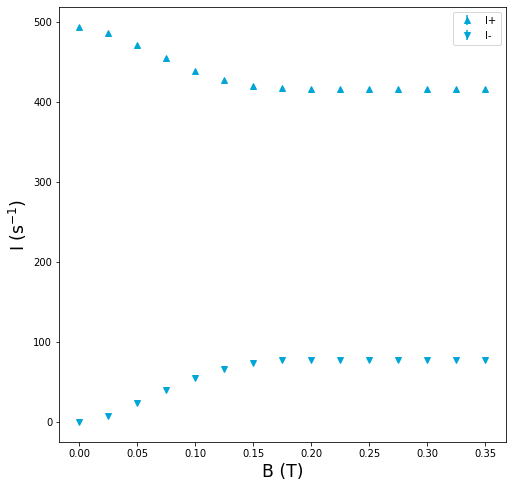

In [38]:
sesans.plot_I(title = False)

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: divide by zero encountered in log
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))
C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))


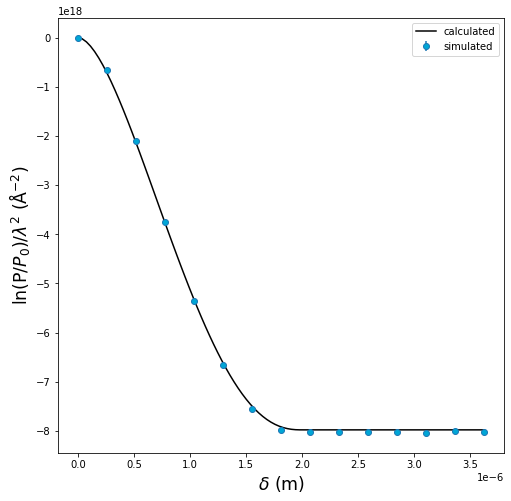

In [39]:
sesans.plot_pol_lambda()

In [40]:
sesans2 = SESANS((0,0.35), 15, lambda0 = 3, ncounts = 1e7)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_29"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_29

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=493.461 Monitor_ERR=0.303094 Monitor_N=9.4489e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_30"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of func

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_39"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_39

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=367.041 Monitor_ERR=0.227324 Monitor_N=9.44934e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_40"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of fun

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_49"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_49

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=366.782 Monitor_ERR=0.22972 Monitor_N=9.44845e+006 "PSD.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans\data_50"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of func

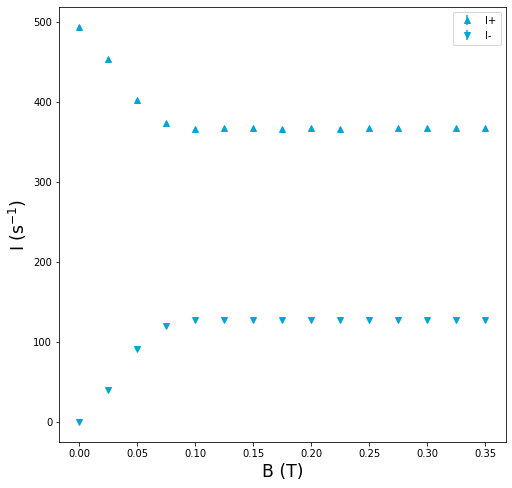

In [41]:
sesans2.plot_I(title = False)

C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: divide by zero encountered in log
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))
C:\Users\wesh-\AppData\Local\Temp/ipykernel_21420/1379709094.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return np.real((1-(zor/2)**2)**0.5*(1+1/8.0*zor**2)+1/2.0*zor**2*(1-(zor/4)**2)*np.log(zor/(2+(4-zor**2)**0.5)))


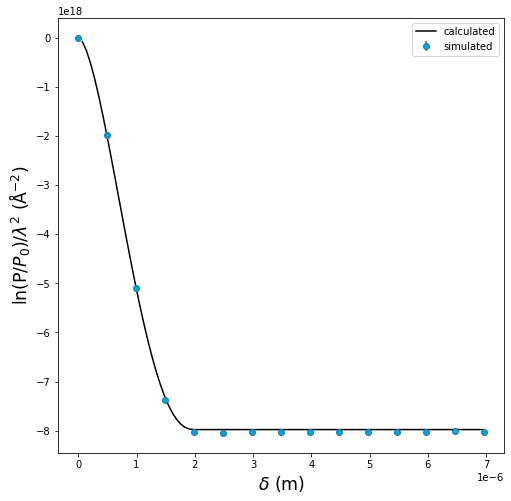

In [42]:
sesans2.plot_pol_lambda()

<h2>TOF SESANS</h2>

In [43]:
def TOF_SESANS_model(analyser, B_prisms, lambda_min = 2, lambda_max = 3, num_wavelengths = 50, radius = 1e-6, pos_polarizer = 0.1,\
                 pos_prism1 = 0.5, dist_between_prisms = 2, dist_prism_sample = 0.2, pos_detector = 5,\
                 phi = 0.015, drho = 6e10, d = 1e-3, foldername = 'data', incoherent_bg = 0, ncounts = 1e4): 
    """Create TOF SESANS mcstas model. All dimensions are in m, wavelenght in AA and B in T.\
    For positive values of polarization I+ is measured, for negative ones I-, outputs wavelength, \
    wavelength error, Intensity, Intensity error"""
    if analyser >= 0: 
        analyser = 1
    elif analyser < 0: 
        analyser = -1
    Instrument = instr.McStas_instr('SESANS')
    
    pos_prism2 = pos_prism1 + dist_between_prisms
    pos_sample = pos_prism2 + dist_prism_sample
    pos_slit = pos_sample - 0.01
    pos_prism3 = pos_sample + dist_prism_sample
    pos_prism4 = pos_prism3 + dist_between_prisms
    pos_analyser = pos_detector - 0.1
    
    prism_x = 85e-3
    prism_y = 35e-3
    
    #adding the source
    Source = Instrument.add_component('Source', 'Source_gen') 
    Source.xwidth = 0.01 #m
    Source.yheight = 0.01 #m
    Source.focus_xw = 0.01 #m
    Source.focus_yh = 0.01 #m
    Source.Lmin = lambda_min #AA
    Source.Lmax = lambda_max #AA
    Source.dist = pos_detector
    
    #adding the polarizer
    Polarizer = Instrument.add_component('Polarizer', 'Set_pol', AT = [0,0,pos_polarizer], RELATIVE = 'Source')
    Polarizer.px = 1
    Polarizer.py = 0
    Polarizer.pz = 0
    Polarizer.normalize = 0
    
    #adding first two prisms
    Prism1 = Instrument.add_component('Prism1', 'Pol_WollatonPrism', AT = [0,0,pos_prism1-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism1.xwidth = prism_x #m
    Prism1.yheight = prism_y #m
    Prism1.zdepth = prism_x #m
    Prism1.Current = B_prisms/(30*1e-4) # 30 G/A
    
    Prism2 = Instrument.add_component('Prism2', 'Pol_WollatonPrism', AT = [0,0,pos_prism2-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism2.xwidth = prism_x #m
    Prism2.yheight = prism_y #m
    Prism2.zdepth = prism_x #m
    Prism2.Current = -B_prisms/(30*1e-4)
    
    
    #adding sample
    Sample = Instrument.add_component('Sample', 'SANS_spheres2', AT = [0,0,pos_sample],\
                                          RELATIVE='Source')
    Sample.xwidth = 0.02 #m
    Sample.yheight = 0.02 #m
    Sample.zthick = d #m
    Sample.R = radius*1e10 #AA 
    Sample.phi = phi
    Sample.dsdw_inc = incoherent_bg #cm^-1
    Sample.drho = drho #cm^-2
    Sample.Qmind = 0.000003
    Sample.Qmaxd = 0.001
    Sample.sc_aim = 0.8
    Sample.sans_aim = 0.95
    Sample.singlesp = 0
    
    #adding second two prisms
    Prism3 = Instrument.add_component('Prism3', 'Pol_WollatonPrism', AT = [0,0,pos_prism3-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism3.xwidth = prism_x #m
    Prism3.yheight = prism_y #m
    Prism3.zdepth = prism_x #m
    Prism3.Current = -B_prisms/(30*1e-4)
    
    Prism4 = Instrument.add_component('Prism4', 'Pol_WollatonPrism', AT = [0,0,pos_prism4-prism_x/2],\
                                      RELATIVE = 'Source')
    Prism4.xwidth = prism_x #m
    Prism4.yheight = prism_y #m
    Prism4.zdepth = prism_x #m
    Prism4.Current = B_prisms/(30*1e-4)
    
    #add analyser
    Analyser = Instrument.add_component('Analyser', 'PolAnalyser_ideal', AT = [0,0,pos_analyser], RELATIVE = 'Source')
    Analyser.mx = analyser
    Analyser.my = 0
    Analyser.mz = 0
    
    #add monitor
    Monitor = Instrument.add_component('Monitor', 'L_monitor', AT = [0,0,pos_detector],RELATIVE = 'Source')
    Monitor.xwidth = 0.011 #m
    Monitor.yheight = 0.011 #m
    Monitor.Lmin = lambda_min
    Monitor.Lmax = lambda_max
    Monitor.nL = num_wavelengths
    Monitor.filename = "\"Monitor\""
    
    data = Instrument.run_full_instrument(foldername = foldername, nmpi=6,\
                                          ncount=ncounts, increment_folder_name = True)
    
    monitor_data = functions.name_search("Monitor", data)
    wl_error = (lambda_max - lambda_min)/num_wavelengths
    return monitor_data.xaxis, wl_error, monitor_data.Intensity, monitor_data.Error

In [44]:
class TOF_SESANS(object): 
    def __init__(self, Bs, lambda_min  = 2, lambda_max = 3, num_wavelengths = 100, radius = 1e-6, pos_polarizer = 0.1,\
                 pos_prism1 = 0.5, dist_between_prisms = 1.5, dist_prism_sample = 0.25, pos_detector = 4.5,\
                phi = 0.015, drho = 6e10, d = 1e-3, foldername = "sesans_tof\\data", incoherent_bg = 0, ncounts = 1e4):
        """SESANS model, B_range is a tuple in T. Runs the SESANS_model() N_B times within B_range,\
        measuring both the intensity of the positive and negative polarized neutrons"""
        I_plus = []
        I_min = []
        I_plus_err = []
        I_min_err = []
        wavelength = []
        wavelength_err = []
        start_time = time.time()
        for B in Bs:
            wl, wl_err, I_plus_B, I_plus_B_err = TOF_SESANS_model(1, B, lambda_min, lambda_max, num_wavelengths,\
                                                  radius, pos_polarizer, pos_prism1, dist_between_prisms,\
                                                  dist_prism_sample, pos_detector, phi, drho, d, foldername,\
                                                  incoherent_bg, ncounts)
            _, _, I_min_B, I_min_B_err = TOF_SESANS_model(-1, B, lambda_min, lambda_max, num_wavelengths,\
                                                  radius, pos_polarizer, pos_prism1, dist_between_prisms,\
                                                  dist_prism_sample, pos_detector, phi, drho, d, foldername,\
                                                  incoherent_bg, ncounts)
            I_plus.append(I_plus_B)
            I_min.append(I_min_B)
            I_plus_err.append(I_plus_B_err)
            I_min_err.append(I_min_B_err)
            wavelength.append(wl)
            wavelength_err.append(wl_err)
        self.I_plus = np.array(I_plus)
        self.I_min = np.array(I_min)
        self.I_plus_err = np.array(I_plus_err)
        self.I_min_err = np.array(I_min_err)
        stop_time = time.time()
        self.wavelength = np.array(wavelength)
        self.wavelength_err = np.array(wavelength_err)
        self.L = dist_between_prisms
        self.B = Bs
        self.radius = radius
        self.time_to_run = stop_time - start_time
        self.phi = phi
        self.drho = drho
        self.d = d
        
    def scattering_power(self):
        """Calculate the scattering power divided by the wavelength squared of the used sample"""
        phi = self.phi
        drho = self.drho *1e4 #m^(-2)
        wavelength = self.wavelength * 1e-10 #m
        d = self.d
        R = self.radius
        return (3/2)*phi*(1-phi)*(drho**2)*d*R
    
    def spin_echo_length(self):
        """Calculates the spin echo length for each B"""
        c = 4.63e14 #T^(-1)m^(-2)
        wavelength = self.wavelength * 1e-10 #m
        wavelength_err = self.wavelength_err * 1e-10 #m
        delta = np.zeros(self.wavelength.shape)
        delta_err = np.zeros(self.wavelength.shape)
        #for each value of B, calculate delta and corresponding error and append in final
        for i, B in enumerate(self.B):
            delta[i,:] = (c*(wavelength[i]**2)*B*self.L)/np.pi
            delta_err[i,:] = ((2*c*wavelength[i]*B*self.L)/np.pi)*wavelength_err[i]
        return delta, delta_err
    
    def polarization(self):
        """Calculates polarization from the intensities and corresponding errors"""
        pol = (self.I_plus - self.I_min) / (self.I_plus + self.I_min)
        sum_err = np.sqrt(self.I_plus_err**2 + self.I_min_err**2)
        pol_err = pol*np.sqrt((sum_err/(self.I_plus - self.I_min))**2 +\
                              (sum_err/(self.I_plus + self.I_min))**2)
        return pol, pol_err
    
    def calculated_pol(self, delta):
        """Calculate theoretical ln(polarization)/lambda^2"""
        wavelength = self.wavelength * 1e-10 #m
        radius = self.radius
        G =  gz_sphere_PY(delta, radius)
        tau = self.scattering_power()
        return (tau*(G-1))
        
    def plot_pol_lambda(self): 
        """Plot the polarization/wavelength^2"""
        wavelength = self.wavelength*1e-10 #m
        wavelength_err = self.wavelength_err * 1e-10 #m
        delta, delta_err = self.spin_echo_length() 
        delta_cal = np.linspace(np.min(delta),\
                                np.max(delta), 100) 
        P_cal = self.calculated_pol(delta_cal)
        pol, pol_err = self.polarization()
        #normalize polarization by ln(P/P0)/lamda^2
        pol_norm = np.log(pol)/wavelength**2
        pol_norm = pol_norm.flatten()
        #error for normalized polarization
        pol_norm_err = np.zeros(self.wavelength.shape)
        for i, B in enumerate(self.B):
            pol_norm_err[i,:] = np.sqrt(((1/(pol[i]*wavelength[i]**2))**2*pol_err[i]**2)\
                                        +(((2*np.log(pol[i]))/wavelength[i]**3)**2)*wavelength_err[i]**2)
        pol_norm_err = pol_norm_err.flatten()
        #get (flattened) spin echo length
        delta = delta.flatten()
        delta_err = delta_err.flatten()
        plt.figure(figsize = (8,8))
        plt.errorbar(delta, pol_norm, yerr = pol_norm_err, xerr = delta_err, marker = 'o', label = 'simulated',\
                    linestyle = 'None', mec = tu_delft_cyan, fillstyle = 'none')
        plt.plot(delta_cal, P_cal, label = 'calculated', color = (0,0,0))
        plt.legend()
        plt.xlabel('$\delta$ (m)', size = 'xx-large')
        plt.ylabel('ln(P/$P_0$)/$\lambda^2$ (Å$^{-2}$)', size = 'xx-large')
    
    def print_runtime(self): 
        time_string = timedelta(seconds = self.time_to_run)
        print('It took ' + str(time_string) + ' to run the simulation')

In [45]:
tof_sesans = TOF_SESANS([0.1, 0.22], num_wavelengths = 50, ncounts = 1e8)

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans_tof\data"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit declaration of function 'getpid'; did you mean 'getcwd'? [-Wimplicit-function-declaration]
INFO: ===
         (negative time, miss next components, rounding errors, Nan, Inf).
INFO: Placing instr file copy SESANS.instr in dataset C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans_tof\data

Instrument parameters for SESANS (SESANS.instr)
INFO: Set_pol(Polarizer): Setting polarization to (1.000000, 0.000000, 0.000000)
Detector: Monitor_I=4.07728e-006 Monitor_ERR=7.51145e-010 Monitor_N=9.48209e+007 "Monitor.dat"

INFO: Using directory: "C:\Users\wesh-\Documents\TUDelft\BEP\BEP_Wesley\sesans_tof\data_0"
INFO: Regenerating c-file: SESANS.c
CFLAGS=
INFO: Recompiling: SESANS.exe
mccode-r.c: In function 'sighandler':
mccode-r.c:3711:64: warning: implicit 

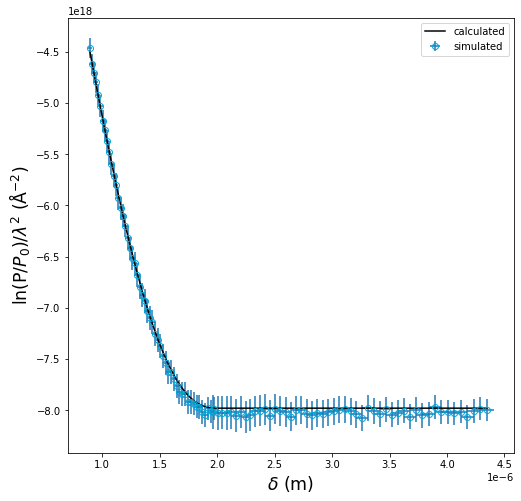

In [46]:
tof_sesans.plot_pol_lambda()